# Reformatting 1000 Genomes triads pedigree file

Original file here: [http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/working/1kGP.3202_samples.pedigree_info.txt](http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/working/1kGP.3202_samples.pedigree_info.txt)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("poster")
%matplotlib inline

In [2]:
df_pedigree = (pd.read_csv("../../data/1000Genomes/1kGP.3202_samples.pedigree_info.txt", sep=" ")
               .assign(sex = lambda x: ['M' if i == 1 else 'F' for i in x["sex"]]))
df_pedigree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3202 entries, 0 to 3201
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sampleID  3202 non-null   object
 1   fatherID  3202 non-null   object
 2   motherID  3202 non-null   object
 3   sex       3202 non-null   object
dtypes: object(4)
memory usage: 100.2+ KB


In [3]:
df_pedigree.head()

,sampleID,fatherID,motherID,sex
0,HG00096,0,0,M
1,HG00097,0,0,F
2,HG00099,0,0,F
3,HG00100,0,0,F
4,HG00101,0,0,M


In [4]:
value_map = {"sampleID": "child", "fatherID": "father", "motherID": "mother"}
df_triads = (df_pedigree[["sampleID", "fatherID", "motherID"]]
             .query("fatherID != '0' and motherID != '0'")             
             .assign(triadID = lambda x: np.arange(0, x.shape[0], 1))
             .melt(id_vars="triadID")
             .assign(
                 role = lambda x: [value_map[i] for i in x["variable"]],
                 pgx_id = lambda x: [f"onekgbs-{i}" for i in x["value"]])
             .drop("variable", axis=1)             
             .sort_values(["triadID", "value"])
             .reset_index(drop=True))

df_triads = df_triads.rename(columns={"value": "sampleID", "variable": "role"}).merge(df_pedigree[["sampleID", "sex"]], on="sampleID")

df_triads

,triadID,sampleID,role,pgx_id,sex
0,0,HG00403,father,onekgbs-HG00403,M
1,0,HG00404,mother,onekgbs-HG00404,F
2,0,HG00405,child,onekgbs-HG00405,F
3,1,HG00406,father,onekgbs-HG00406,M
4,1,HG00407,mother,onekgbs-HG00407,F
...,...,...,...,...,...
1801,600,NA20279,child,onekgbs-NA20279,M
1802,600,NA20282,mother,onekgbs-NA20282,F
1803,601,NA20356,father,onekgbs-NA20356,M
1804,601,NA20357,mother,onekgbs-NA20357,F


### Parents with multiple children

Looks like some parents have more than one child that is part of the 1000 Genomes data, or a child itself has a child that then also becomes part of the 1000 Genomes data. This means some samples show up in more than one triad. I don't think this is an issue, as long as we keep it in mind when we're e.g. querying Progenetix.

In [5]:
print(df_triads.shape[0], df_triads["sampleID"].nunique())
df_triads["sampleID"].value_counts().sort_values()[df_triads["sampleID"].value_counts().sort_values() > 1].sort_index()

1806 1793


sampleID
HG00656    2
HG00657    2
HG00702    2
HG03642    2
HG03679    2
HG03943    2
HG03944    2
NA19660    2
NA19661    2
NA19675    2
NA19678    2
NA19679    2
NA19685    2
Name: count, dtype: int64

In [6]:
df_triads.query("sampleID == 'HG03642'")

,triadID,sampleID,role,pgx_id,sex
1320,440,HG03642,mother,onekgbs-HG03642,F
1321,441,HG03642,mother,onekgbs-HG03642,F


In [7]:
df_triads.query("triadID == 440")

,triadID,sampleID,role,pgx_id,sex
1320,440,HG03642,mother,onekgbs-HG03642,F
1322,440,HG03679,father,onekgbs-HG03679,M
1324,440,HG04204,child,onekgbs-HG04204,M


In [8]:
df_triads.query("triadID == 441")

,triadID,sampleID,role,pgx_id,sex
1321,441,HG03642,mother,onekgbs-HG03642,F
1323,441,HG03679,father,onekgbs-HG03679,M
1325,441,HG04215,child,onekgbs-HG04215,M


# Adding ftp links to alignment files

In [6]:
def load_ena_index_file(url):
    df = pd.read_csv(
        url,
        comment="#",
        header=None,
        sep="\t",
        usecols=[0, 9, 10],
        names=["ENA_FILE_PATH", "sampleID", "population"]
    )

    return df

In [7]:
df_related = load_ena_index_file("https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/1000G_698_related_high_coverage.sequence.index")
df_unrelated = load_ena_index_file("https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/1000G_2504_high_coverage.sequence.index")

df_triads = df_triads.merge(pd.concat([df_related, df_unrelated], axis=0), on="sampleID", how="left")
df_triads

,triadID,sampleID,role,pgx_id,sex,ENA_FILE_PATH,population
0,0,HG00403,father,onekgbs-HG00403,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
1,0,HG00404,mother,onekgbs-HG00404,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
2,0,HG00405,child,onekgbs-HG00405,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR398/ERR398...,CHS
3,1,HG00406,father,onekgbs-HG00406,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
4,1,HG00407,mother,onekgbs-HG00407,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
...,...,...,...,...,...,...,...
1801,600,NA20279,child,onekgbs-NA20279,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR398/ERR398...,ASW
1802,600,NA20282,mother,onekgbs-NA20282,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR323/ERR323...,ASW
1803,601,NA20356,father,onekgbs-NA20356,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR323/ERR323...,ASW
1804,601,NA20357,mother,onekgbs-NA20357,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR323/ERR323...,ASW


In [9]:
df_triads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   triadID        1806 non-null   int64 
 1   sampleID       1806 non-null   object
 2   role           1806 non-null   object
 3   pgx_id         1806 non-null   object
 4   sex            1806 non-null   object
 5   ENA_FILE_PATH  1803 non-null   object
 6   population     1803 non-null   object
dtypes: int64(1), object(6)
memory usage: 98.9+ KB


In [8]:
df_triads[df_triads["ENA_FILE_PATH"].isna()]

,triadID,sampleID,role,pgx_id,sex,ENA_FILE_PATH,population
796,265,HG02635,mother,onekgbs-HG02635,F,NaN,NaN
988,329,HG03025,mother,onekgbs-HG03025,F,NaN,NaN
1119,373,HG03366,mother,onekgbs-HG03366,F,NaN,NaN


There are three samples in df_triads for which no information is included in the index files from ENA. Not sure why this is... If I look these samples up manually in the 1000 Genomes data portal ([https://www.internationalgenome.org/data-portal/sample](https://www.internationalgenome.org/data-portal/sample)), they do have alignments and population info available. So I'll just add them manually

In [11]:
url_list = [
    "ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR3242420/HG02635.final.cram",
    "ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR3242524/HG03025.final.cram",
    "ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR3242599/HG03366.final.cram"
]
population_list = [
    "GWD",
    "GWD",
    "ESN"
]
# seems usafe since assignment is position based but I cannot figure out how to do this nicely
df_triads.loc[df_triads["ENA_FILE_PATH"].isna(), "ENA_FILE_PATH"] = url_list
df_triads.loc[df_triads["population"].isna(), "population"] = population_list
df_triads

,triadID,sampleID,role,pgx_id,sex,ENA_FILE_PATH,population
0,0,HG00403,father,onekgbs-HG00403,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
1,0,HG00404,mother,onekgbs-HG00404,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
2,0,HG00405,child,onekgbs-HG00405,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR398/ERR398...,CHS
3,1,HG00406,father,onekgbs-HG00406,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
4,1,HG00407,mother,onekgbs-HG00407,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
...,...,...,...,...,...,...,...
1801,600,NA20279,child,onekgbs-NA20279,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR398/ERR398...,ASW
1802,600,NA20282,mother,onekgbs-NA20282,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR323/ERR323...,ASW
1803,601,NA20356,father,onekgbs-NA20356,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR323/ERR323...,ASW
1804,601,NA20357,mother,onekgbs-NA20357,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR323/ERR323...,ASW


In [12]:
df_triads[df_triads["ENA_FILE_PATH"].isna()]

,triadID,sampleID,role,pgx_id,sex,ENA_FILE_PATH,population


In [60]:
df_triads.to_csv(
    "../../data/1000Genomes/1000_genomes_triad_pedigrees.csv", 
    index=True, # include index, could be used for sbatch-array later on?
    sep=",")

## Taking a subset of 100 family trios for initial analysis

/var/folders/2z/jqp3h4fs3lsfdqvrjxl783f00000gn/T/ipykernel_2588/4130631656.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


18

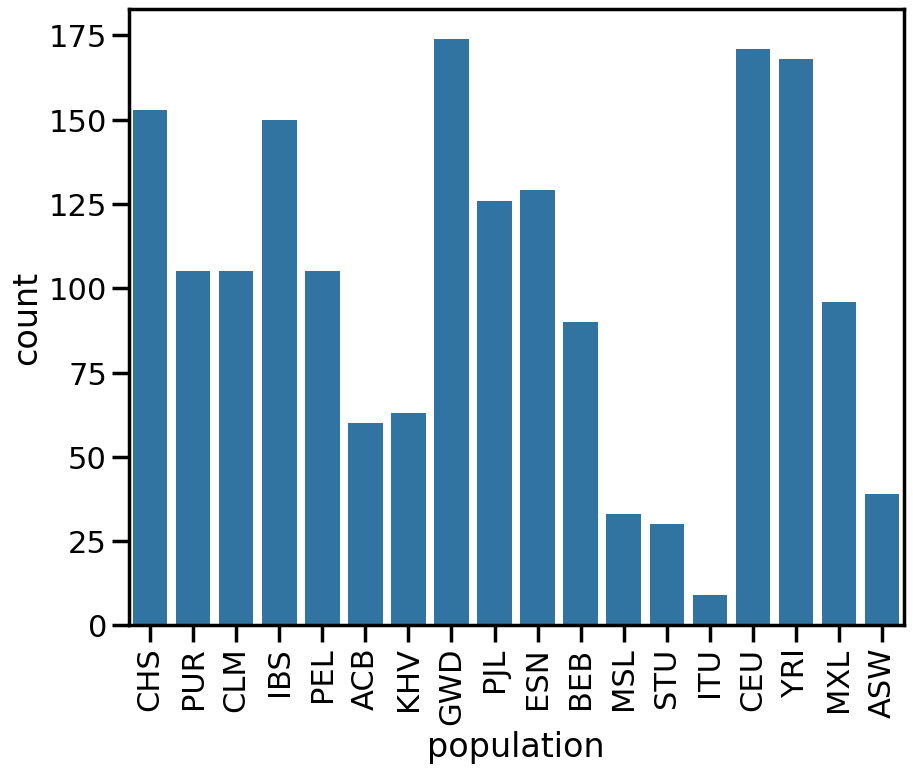

In [24]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(
    data=df_triads,
    x="population"
)

ax.set(xticks=ax.get_xticks())
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
df_triads["population"].nunique()

In [26]:
df_triads["population"].value_counts()

population
GWD    174
CEU    171
YRI    168
CHS    153
IBS    150
ESN    129
PJL    126
PUR    105
CLM    105
PEL    105
MXL     96
BEB     90
KHV     63
ACB     60
ASW     39
MSL     33
STU     30
ITU      9
Name: count, dtype: int64

The ITU population is too small to allow for balanced sampling, so we drop it for now

In [33]:
df_triads = df_triads.query("population != 'ITU'")
df_triads["population"].nunique()

17

17 populations left. If we sample 6 trios from each, we will end up with 102 trios in total (306 samples). This should do for now.

In [53]:
rng = np.random.default_rng(42)
samps_per_pop = 6

df_triads_balanced_samp = []
for name, data in df_triads.groupby("population"):
    trios = data["triadID"].unique()
    samp = rng.choice(trios, samps_per_pop, replace=False)
    df_triads_balanced_samp.append(data.loc[data["triadID"].isin(samp)])

df_triads_balanced_samp = pd.concat(df_triads_balanced_samp).sort_values(["triadID", "sampleID"]).reset_index(drop=True)
df_triads_balanced_samp

,triadID,sampleID,role,pgx_id,sex,ENA_FILE_PATH,population
0,3,HG00421,father,onekgbs-HG00421,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
1,3,HG00422,mother,onekgbs-HG00422,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
2,3,HG00423,child,onekgbs-HG00423,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR398/ERR398...,CHS
3,21,HG00542,father,onekgbs-HG00542,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
4,21,HG00543,mother,onekgbs-HG00543,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
...,...,...,...,...,...,...,...
301,600,NA20279,child,onekgbs-NA20279,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR398/ERR398...,ASW
302,600,NA20282,mother,onekgbs-NA20282,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR323/ERR323...,ASW
303,601,NA20356,father,onekgbs-NA20356,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR323/ERR323...,ASW
304,601,NA20357,mother,onekgbs-NA20357,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR323/ERR323...,ASW


17

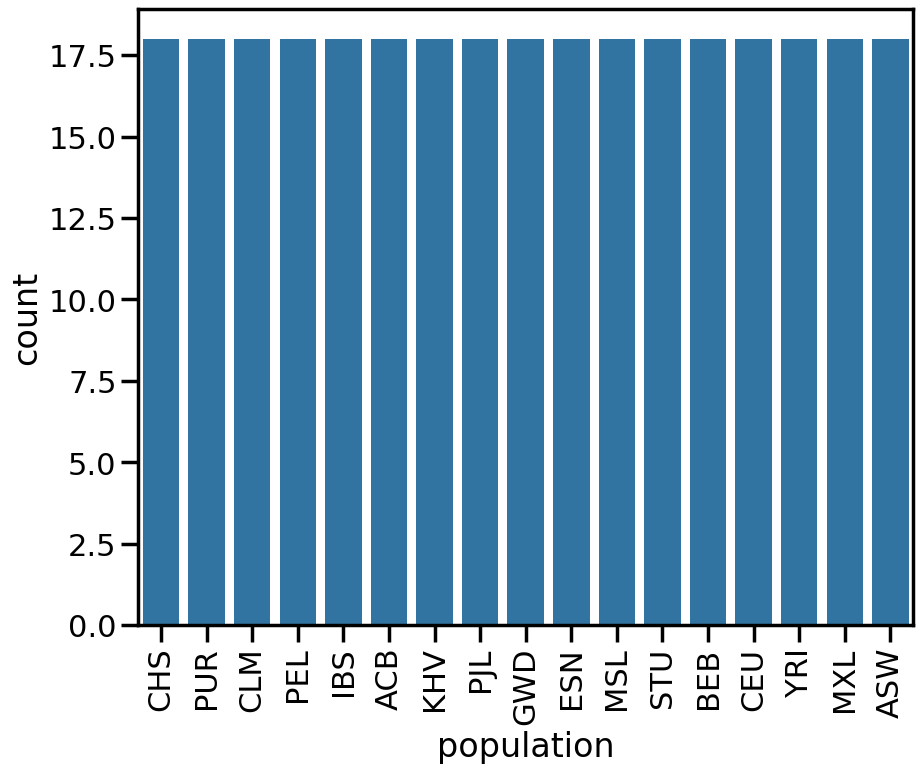

In [61]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(
    data=df_triads_balanced_samp,
    x="population"
)

ax.set(xticks=ax.get_xticks())
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

df_triads_balanced_samp["population"].nunique()

In [63]:
df_triads_balanced_samp.to_csv(
    "../../data/1000Genomes/1000_genomes_triad_pedigrees_subsamp.csv", 
    index=True, # include index, could be used for sbatch-array later on?
    sep=",")